<a href="https://colab.research.google.com/github/NaDaGyeong/monodepth2/blob/master/monodepth2_edge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Example prediction on a single test image

This notebook gives example code to make a single disparity prediction for one test image.

The file `test_simple.py` shows a more complete version of this code, which additionally:
- Can run on GPU or CPU (this notebook only runs on CPU)
- Can predict for a whole folder of images, not just a single image
- Saves predictions to `.npy` files and disparity images.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/monodepth2

/content/drive/MyDrive/monodepth2


In [3]:
from __future__ import absolute_import, division, print_function
%matplotlib inline

import os
import numpy as np
import PIL.Image as pil
import matplotlib.pyplot as plt

import torch
from torchvision import transforms

import networks
from utils import download_model_if_doesnt_exist

# Only Infra

## Setting up network and loading weights

In [4]:
model_name = "mono_640x192"

download_model_if_doesnt_exist(model_name)
encoder_path = os.path.join("models", model_name, "encoder.pth")
depth_decoder_path = os.path.join("models", model_name, "depth.pth")

# LOADING PRETRAINED MODEL
encoder = networks.ResnetEncoder(18, False)
depth_decoder = networks.DepthDecoder(num_ch_enc=encoder.num_ch_enc, scales=range(4))

loaded_dict_enc = torch.load(encoder_path, map_location='cpu')
filtered_dict_enc = {k: v for k, v in loaded_dict_enc.items() if k in encoder.state_dict()}
encoder.load_state_dict(filtered_dict_enc)

loaded_dict = torch.load(depth_decoder_path, map_location='cpu')
depth_decoder.load_state_dict(loaded_dict)

encoder.eval()
depth_decoder.eval();

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


## Loading the test image and preprocessing

In [5]:
image_path = "/content/drive/MyDrive/train_images/2.jpg"

input_image = pil.open(image_path).convert('RGB')
original_width, original_height = input_image.size

feed_height = loaded_dict_enc['height']
feed_width = loaded_dict_enc['width']
input_image_resized = input_image.resize((feed_width, feed_height), pil.LANCZOS)

input_image_pytorch = transforms.ToTensor()(input_image_resized).unsqueeze(0)

In [17]:
str(input_image)

'<PIL.Image.Image image mode=RGB size=512x352 at 0x7F58ABC453D0>'

## Prediction using the PyTorch model

In [6]:
with torch.no_grad():
    features = encoder(input_image_pytorch)
    outputs = depth_decoder(features)

disp = outputs[("disp", 0)]

## Plotting

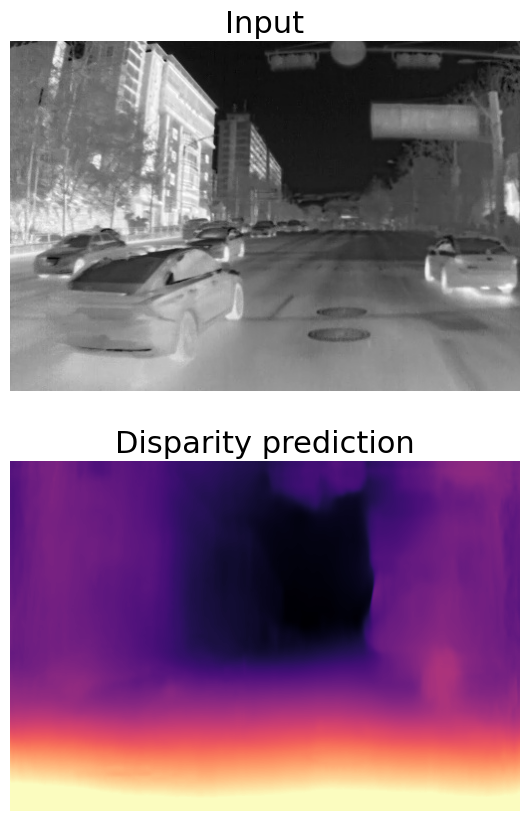

In [7]:
disp_resized = torch.nn.functional.interpolate(disp,
    (original_height, original_width), mode="bilinear", align_corners=False)

# Saving colormapped depth image
disp_resized_np = disp_resized.squeeze().cpu().numpy()
vmax = np.percentile(disp_resized_np, 95)

plt.figure(figsize=(10, 10))
plt.subplot(211)
plt.imshow(input_image)
plt.title("Input", fontsize=22)
plt.axis('off')

plt.subplot(212)
plt.imshow(disp_resized_np, cmap='magma', vmax=vmax)
plt.title("Disparity prediction", fontsize=22)
plt.axis('off');

# Canny Transformation

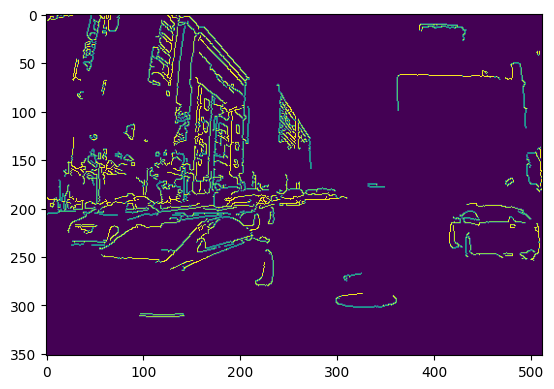

In [35]:
import cv2

src = cv2.imread(image_path, cv2.IMREAD_COLOR)
gray = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)

sobel = cv2.Sobel(gray, cv2.CV_8U, 1, 0, 3)
laplacian = cv2.Laplacian(gray, cv2.CV_8U, ksize=3)
canny = cv2.Canny(src, 100, 255)


plt.imshow(canny)
'''
cv2.imshow("sobel", sobel)
cv2.imshow("laplacian", laplacian)
cv2.imshow("canny", canny)
'''
cv2.waitKey()
cv2.destroyAllWindows()

In [16]:
type(canny)

numpy.ndarray

In [22]:
#input_image = pil.open(image_path).convert('RGB')
import numpy as np
from PIL import Image
input_image = Image.fromarray(canny)
input_image = input_image.convert('RGB')
original_width, original_height = input_image.size

feed_height = loaded_dict_enc['height']
feed_width = loaded_dict_enc['width']
input_image_resized = input_image.resize((feed_width, feed_height), pil.LANCZOS)

input_image_pytorch = transforms.ToTensor()(input_image_resized).unsqueeze(0)

In [23]:
with torch.no_grad():
    features = encoder(input_image_pytorch)
    outputs = depth_decoder(features)

disp = outputs[("disp", 0)]

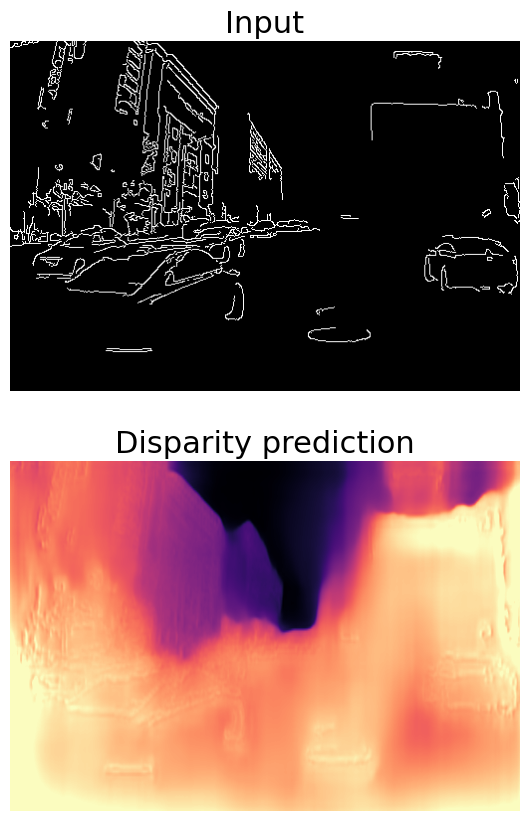

In [24]:
disp_resized = torch.nn.functional.interpolate(disp,
    (original_height, original_width), mode="bilinear", align_corners=False)

# Saving colormapped depth image
disp_resized_np = disp_resized.squeeze().cpu().numpy()
vmax = np.percentile(disp_resized_np, 95)

plt.figure(figsize=(10, 10))
plt.subplot(211)
plt.imshow(input_image)
plt.title("Input", fontsize=22)
plt.axis('off')

plt.subplot(212)
plt.imshow(disp_resized_np, cmap='magma', vmax=vmax)
plt.title("Disparity prediction", fontsize=22)
plt.axis('off');

# Infa+Edge

In [48]:
image_path = "/content/drive/MyDrive/train_images/2.jpg"

img = pil.open(image_path).convert('RGB')
img = np.array(img)
img

array([[[ 54,  54,  54],
        [ 51,  51,  51],
        [ 44,  44,  44],
        ...,
        [ 64,  64,  64],
        [ 62,  62,  62],
        [ 39,  39,  39]],

       [[ 48,  48,  48],
        [ 40,  40,  40],
        [ 37,  37,  37],
        ...,
        [ 55,  55,  55],
        [ 64,  64,  64],
        [ 51,  51,  51]],

       [[ 41,  41,  41],
        [ 37,  37,  37],
        [ 39,  39,  39],
        ...,
        [ 42,  42,  42],
        [ 64,  64,  64],
        [ 65,  65,  65]],

       ...,

       [[165, 165, 165],
        [167, 167, 167],
        [166, 166, 166],
        ...,
        [152, 152, 152],
        [152, 152, 152],
        [151, 151, 151]],

       [[166, 166, 166],
        [166, 166, 166],
        [164, 164, 164],
        ...,
        [152, 152, 152],
        [152, 152, 152],
        [152, 152, 152]],

       [[167, 167, 167],
        [166, 166, 166],
        [163, 163, 163],
        ...,
        [152, 152, 152],
        [152, 152, 152],
        [152, 152, 152]]

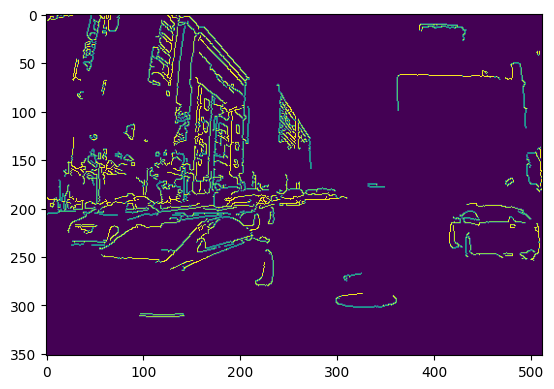

In [38]:
import cv2

src = cv2.imread(image_path, cv2.IMREAD_COLOR)
gray = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)

sobel = cv2.Sobel(gray, cv2.CV_8U, 1, 0, 3)
laplacian = cv2.Laplacian(gray, cv2.CV_8U, ksize=3)
canny = cv2.Canny(src, 100, 255)


plt.imshow(canny)
'''
cv2.imshow("sobel", sobel)
cv2.imshow("laplacian", laplacian)
cv2.imshow("canny", canny)
'''
cv2.waitKey()
cv2.destroyAllWindows()

In [39]:
#input_image = pil.open(image_path).convert('RGB')
import numpy as np
from PIL import Image
input_image = Image.fromarray(canny)
input_image = input_image.convert('RGB')
original_width, original_height = input_image.size

feed_height = loaded_dict_enc['height']
feed_width = loaded_dict_enc['width']
input_image_resized = input_image.resize((feed_width, feed_height), pil.LANCZOS)

input_image_pytorch = transforms.ToTensor()(input_image_resized).unsqueeze(0)

In [47]:
lines = np.array(input_image)
lines

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

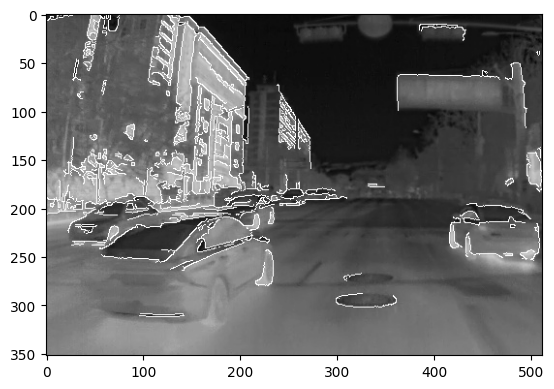

In [52]:
def weighted_img(img, initial_img, a=0.8, b=1., lamb=0.):
  return cv2.addWeighted(initial_img, a, img, b, lamb)

lines_edges = weighted_img(lines, img, a=0.8, b=1., lamb=0.)

plt.imshow(lines_edges)
plt.show()

In [55]:
str(lines_edges)

'[[[ 43  43  43]\n  [ 41  41  41]\n  [ 35  35  35]\n  ...\n  [ 51  51  51]\n  [ 50  50  50]\n  [ 31  31  31]]\n\n [[ 38  38  38]\n  [ 32  32  32]\n  [ 30  30  30]\n  ...\n  [ 44  44  44]\n  [ 51  51  51]\n  [ 41  41  41]]\n\n [[ 33  33  33]\n  [ 30  30  30]\n  [ 31  31  31]\n  ...\n  [ 34  34  34]\n  [ 51  51  51]\n  [ 52  52  52]]\n\n ...\n\n [[132 132 132]\n  [134 134 134]\n  [133 133 133]\n  ...\n  [122 122 122]\n  [122 122 122]\n  [121 121 121]]\n\n [[133 133 133]\n  [133 133 133]\n  [131 131 131]\n  ...\n  [122 122 122]\n  [122 122 122]\n  [122 122 122]]\n\n [[134 134 134]\n  [133 133 133]\n  [130 130 130]\n  ...\n  [122 122 122]\n  [122 122 122]\n  [122 122 122]]]'

In [56]:
input_image = Image.fromarray(lines_edges)

In [57]:
original_width, original_height = input_image.size

feed_height = loaded_dict_enc['height']
feed_width = loaded_dict_enc['width']
input_image_resized = input_image.resize((feed_width, feed_height), pil.LANCZOS)

input_image_pytorch = transforms.ToTensor()(input_image_resized).unsqueeze(0)

In [58]:
str(input_image)

'<PIL.Image.Image image mode=RGB size=512x352 at 0x7F5886F58D90>'

In [59]:
with torch.no_grad():
    features = encoder(input_image_pytorch)
    outputs = depth_decoder(features)

disp = outputs[("disp", 0)]

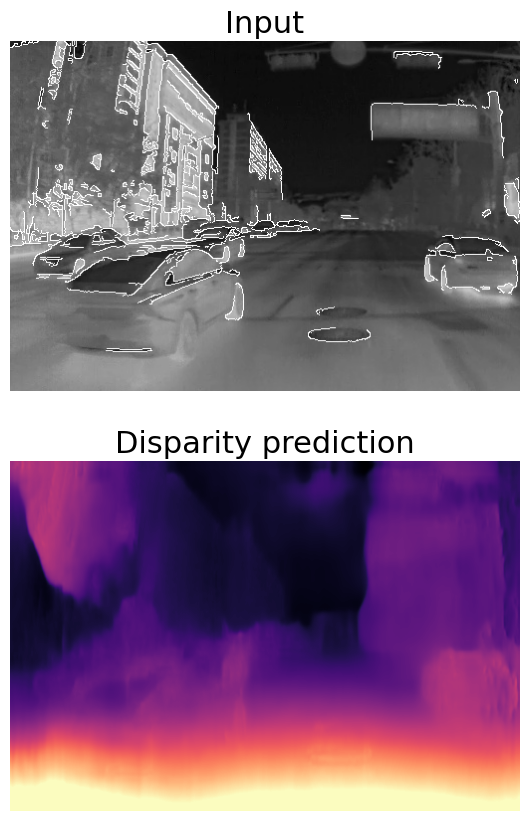

In [60]:
disp_resized = torch.nn.functional.interpolate(disp,
    (original_height, original_width), mode="bilinear", align_corners=False)

# Saving colormapped depth image
disp_resized_np = disp_resized.squeeze().cpu().numpy()
vmax = np.percentile(disp_resized_np, 95)

plt.figure(figsize=(10, 10))
plt.subplot(211)
plt.imshow(input_image)
plt.title("Input", fontsize=22)
plt.axis('off')

plt.subplot(212)
plt.imshow(disp_resized_np, cmap='magma', vmax=vmax)
plt.title("Disparity prediction", fontsize=22)
plt.axis('off');